This is the Project 1 for the Term 1. This file is supposed to mark the lane lines for the video.

Import the needed libraries.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import tensorflow as tf
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
import math

def grayscale(img):
# Applies the Grayscale transform. This will return an image with only one color channel
# NOTE: to see the returned image as grayscale(assuming your grayscaled image is called 'gray')
# you should call plt.imshow(gray, cmap='gray')
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    # Applies the Canny transform
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    # Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    # Applies an image mask. Only keeps the region of the image defined by the polygon formed from `vertices`. 
    # The rest of the image is set to black. Vertices` should be a numpy array of integer points.
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lanes(line_img, lines)
    return line_img

def draw_lanes(img, lines, color=[255, 0, 0], thickness=8):
    left_lines, right_lines = [], []
    for line in lines:
        for x1, y1, x2, y2 in line:
            k = (y2 - y1) / (x2 - x1)
            if k < 0:
                left_lines.append(line)
            else:
                right_lines.append(line)
  
    if (len(left_lines) <= 0 or len(right_lines) <= 0):
        return img
  
    clean_lines(left_lines, 0.1)
    clean_lines(right_lines, 0.1)
    left_points = [(x1, y1) for line in left_lines for x1,y1,x2,y2 in line]
    left_points = left_points + [(x2, y2) for line in left_lines for x1,y1,x2,y2 in line]
    right_points = [(x1, y1) for line in right_lines for x1,y1,x2,y2 in line]
    right_points = right_points + [(x2, y2) for line in right_lines for x1,y1,x2,y2 in line]
  
    left_vtx = extend_lane(left_points, 325, img.shape[0])
    right_vtx = extend_lane(right_points, 325, img.shape[0])
  
    cv2.line(img, left_vtx[0], left_vtx[1], color, thickness)
    cv2.line(img, right_vtx[0], right_vtx[1], color, thickness)
    return img
  
def clean_lines(lines, threshold):
    slope = [(y2 - y1) / (x2 - x1) for line in lines for x1, y1, x2, y2 in line]
    while len(lines) > 0:
        mean = np.mean(slope)
        diff = [abs(s - mean) for s in slope]
        idx = np.argmax(diff)
        if diff[idx] > threshold:
            slope.pop(idx)
            lines.pop(idx)
        else:
             break
    return lines
  
def extend_lane(point_list, ymin, ymax):
    x = [p[0] for p in point_list]
    y = [p[1] for p in point_list]
    fit = np.polyfit(y, x, 1)
    fit_fn = np.poly1d(fit)
  
    xmin = int(fit_fn(ymin))
    xmax = int(fit_fn(ymax))
  
    return [(xmin, ymin), (xmax, ymax)]

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    #`img` is the output of the hough_lines(), An image with lines drawn on it.Should be a blank image (all black) with lines drawn on it.
    #`initial_img` should be the image before any processing.
    
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
def picture_process(img):
    grayimg = grayscale(img)
    blurimg = gaussian_blur(grayimg, 5)
    edges = canny(blurimg, 50, 150)

    imshape = img.shape
    vertices = np.array([[(60,imshape[0]),(460, 320), (520, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    maskededges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    
    line_img = hough_lines(maskededges, rho, theta, threshold, min_line_length, max_line_gap)

    combo = cv2.addWeighted(img, 0.8, line_img, 1, 0)
    
    return combo

[MoviePy] >>>> Building video solidYellowLeftLane.mp4
[MoviePy] Writing video solidYellowLeftLane.mp4


100%|███████████████████████████████████████▉| 681/682 [00:28<00:00, 24.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidYellowLeftLane.mp4 

Wall time: 29 s


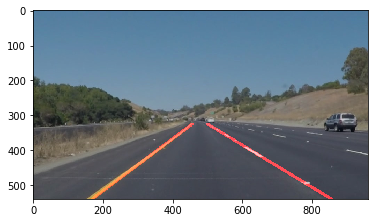

In [4]:
img = mpimg.imread('solidYellowCurve.jpg')
combo = picture_process(img)
plt.imshow(combo)
new_clip_output = 'solidYellowLeftLane.mp4'
test_clip = VideoFileClip("solidYellowLeft.mp4")
new_clip = test_clip.fl_image(picture_process) #NOTE: this function expects color images!!
%time new_clip.write_videofile(new_clip_output, audio=False)

HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))